In [1]:
%pip install keras
%pip install tensorflow
%pip install pydot
%pip install opencv-python
%pip install scikeras

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D 
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from keras import backend as K
from keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import class_weight
from sklearn.model_selection import GridSearchCV
import tensorflow as tf

import cv2
import os
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

programador = "Vasco"
RSEED = 0

In [3]:
#para fazer a leitura das imagens de diferentes tamanhos
labels = ['no', 'yes']
img_size = 299
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #read in RGB
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

Weight for class 0: 1.29
Weight for class 1: 0.82


C:\Users\Vasco Costa\AppData\Local\Temp\ipykernel_12872\2626139651.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


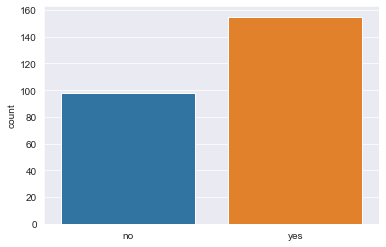

In [4]:
if programador == "Vasco_portatil":
    data = get_data("C:\\Users\\Vasco\\OneDrive - Universidade de Aveiro\\Grupo\\AIA\\dataset")
elif programador == "Vasco":
    data = get_data("C:\\Users\\Vasco Costa\\OneDrive - Universidade de Aveiro\\Grupo\\AIA\\dataset")
elif programador == "Tiago":
    data = get_data("C:\\Users\\Tiago\\Universidade de Aveiro\\Vasco Costa - AIA\dataset")

#print(data)
l = []
count_0 = 0
count_1 = 0
for i in data:
    if(i[1] == 0):
        l.append(labels[0])
        count_0 += 1
    else:
        l.append(labels[1])
        count_1 += 1
sns.set_style('darkgrid')
sns.countplot(l)

weight_for_0 = (1 / count_0)*(count_0+count_1)/2.0 
weight_for_1 = (1 / count_1)*(count_0+count_1)/2.0 

class_weights = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Text(0.5, 1.0, 'yes')

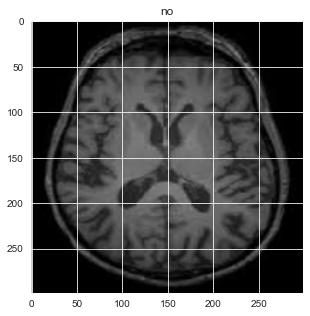

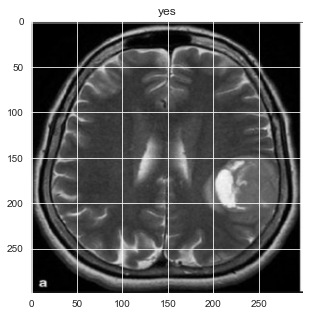

In [5]:
plt.figure(figsize = (5,5))
plt.imshow(data[1][0])
plt.title(labels[data[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(data[-1][0])
plt.title(labels[data[-1][1]])

In [6]:
x = []
y = []

for feature, label in data:
    x.append(feature)
    y.append(label)

x = np.array(x) / 255
#x = x[..., np.newaxis]
y = np.array(y).reshape((-1,1))

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=RSEED)

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [8]:
def create_model(optimizer='adam',loss='binary_crossentropy'):
    base_model = tf.keras.applications.InceptionV3(
                    weights='imagenet', 
                    include_top=False, 
                    input_shape=(img_size,img_size,3))
    base_model.trainable = False
    model_inceptionv3 = tf.keras.Sequential()
    model_inceptionv3.add(base_model)
    model_inceptionv3.add(tf.keras.layers.Flatten())
    model_inceptionv3.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    model_inceptionv3.compile(
                    loss=loss, 
                    optimizer=optimizer,
                    metrics=['acc', f1_m, recall_m, precision_m])

    return model_inceptionv3

In [9]:
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
losses = ['binary_crossentropy','poisson','kl_divergence']
param_grid = dict(model__optimizer = optimizer, model__loss = losses)

checkpoint = tf.keras.callbacks.ModelCheckpoint('model/inceptionv3_best_hyper.h5', monitor='acc', verbose=1, mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="acc", mode="max",restore_best_weights=True, patience=5)
callbacks_list = [checkpoint, early]

model = KerasClassifier(model=create_model, epochs=50, batch_size=10, verbose=1, callbacks=callbacks_list)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3) # cuidado
grid_result = grid.fit(x_train, y_train, callbacks=callbacks_list)

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
12 fits failed out of a total of 63.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "c:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Vasco Costa\AppData\Roaming\Python\Python39\site-packages\scikeras\wrappers.py", line 1494, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "C:\Users\Vasco Costa\AppData\Roaming\Python\Python39\site-packages\scikeras\wrappers.py", line 762, in fit
    self._fit(


Epoch 1/50
18/18 [==============================] - ETA: 0s - loss: 1.5146 - acc: 0.7571 - f1_m: 0.7693 - recall_m: 0.7870 - precision_m: 0.7891
Epoch 1: acc improved from -inf to 0.75706, saving model to model\inceptionv3_best_hyper.h5
18/18 [==============================] - 11s 380ms/step - loss: 1.5146 - acc: 0.7571 - f1_m: 0.7693 - recall_m: 0.7870 - precision_m: 0.7891
Epoch 2/50
18/18 [==============================] - ETA: 0s - loss: 0.2159 - acc: 0.9322 - f1_m: 0.9472 - recall_m: 0.9524 - precision_m: 0.9509
Epoch 2: acc improved from 0.75706 to 0.93220, saving model to model\inceptionv3_best_hyper.h5
18/18 [==============================] - 6s 362ms/step - loss: 0.2159 - acc: 0.9322 - f1_m: 0.9472 - recall_m: 0.9524 - precision_m: 0.9509
Epoch 3/50
18/18 [==============================] - ETA: 0s - loss: 0.0429 - acc: 0.9887 - f1_m: 0.9889 - recall_m: 1.0000 - precision_m: 0.9815
Epoch 3: acc improved from 0.93220 to 0.98870, saving model to model\inceptionv3_best_hyper.h5
18

In [10]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.853107 using {'model__loss': 'binary_crossentropy', 'model__optimizer': 'Adamax'}
nan (nan) with: {'model__loss': 'binary_crossentropy', 'model__optimizer': 'SGD'}
nan (nan) with: {'model__loss': 'binary_crossentropy', 'model__optimizer': 'RMSprop'}
nan (nan) with: {'model__loss': 'binary_crossentropy', 'model__optimizer': 'Adagrad'}
nan (nan) with: {'model__loss': 'binary_crossentropy', 'model__optimizer': 'Adadelta'}
nan (nan) with: {'model__loss': 'binary_crossentropy', 'model__optimizer': 'Adam'}
0.853107 (0.021139) with: {'model__loss': 'binary_crossentropy', 'model__optimizer': 'Adamax'}
nan (nan) with: {'model__loss': 'binary_crossentropy', 'model__optimizer': 'Nadam'}
0.598870 (0.007990) with: {'model__loss': 'poisson', 'model__optimizer': 'SGD'}
0.615819 (0.194403) with: {'model__loss': 'poisson', 'model__optimizer': 'RMSprop'}
0.598870 (0.007990) with: {'model__loss': 'poisson', 'model__optimizer': 'Adagrad'}
0.689266 (0.111859) with: {'model__loss': 'poisson', 'model

In [11]:
best_parameters = grid_result.best_params_
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.2, # Randomly zoom image 
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip = True,  # randomly flip images
    vertical_flip = True)  # randomly flip images

datagen.fit(x_train,seed=RSEED)
model = create_model(optimizer=best_parameters["model__optimizer"],loss=best_parameters["model__loss"])
history = model.fit(x_train,y_train,
        validation_data=(x_test,y_test),
        epochs=50, 
        verbose=True,
        callbacks=callbacks_list,
        class_weight=class_weights)

Epoch 1/50
6/6 [==============================] - ETA: 0s - loss: 2.9950 - acc: 0.5932 - f1_m: 0.5525 - recall_m: 0.5502 - precision_m: 0.6551
Epoch 1: acc improved from -inf to 0.59322, saving model to model\inceptionv3_best_hyper.h5
6/6 [==============================] - 13s 2s/step - loss: 2.9950 - acc: 0.5932 - f1_m: 0.5525 - recall_m: 0.5502 - precision_m: 0.6551 - val_loss: 0.5090 - val_acc: 0.9211 - val_f1_m: 0.9516 - val_recall_m: 0.9815 - val_precision_m: 0.9244
Epoch 2/50
6/6 [==============================] - ETA: 0s - loss: 0.8072 - acc: 0.8757 - f1_m: 0.9113 - recall_m: 0.9841 - precision_m: 0.8571
Epoch 2: acc improved from 0.59322 to 0.87571, saving model to model\inceptionv3_best_hyper.h5
6/6 [==============================] - 7s 1s/step - loss: 0.8072 - acc: 0.8757 - f1_m: 0.9113 - recall_m: 0.9841 - precision_m: 0.8571 - val_loss: 0.7464 - val_acc: 0.8289 - val_f1_m: 0.8741 - val_recall_m: 0.8148 - val_precision_m: 0.9563
Epoch 3/50
6/6 [==============================

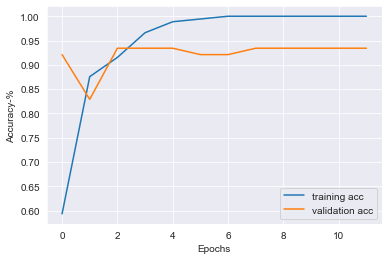

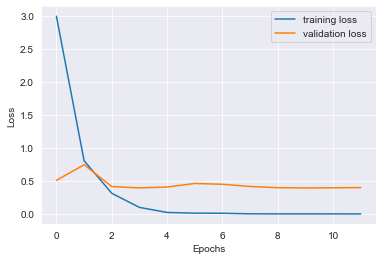

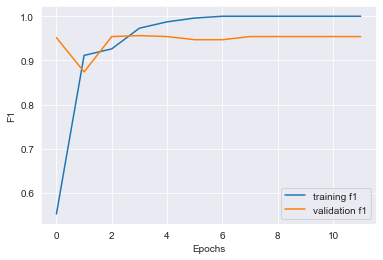

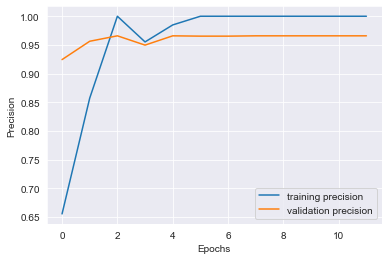

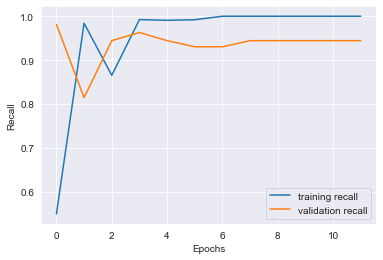

In [12]:
def plot_learning_curve(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    f1 = history.history['f1_m']
    val_f1 = history.history['val_f1_m']
    precision = history.history['precision_m']
    val_precision = history.history['val_precision_m']
    recall = history.history['recall_m']
    val_recall = history.history['val_recall_m']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy-%')
    plt.legend()
    plt.savefig("C:\\Users\\Vasco Costa\\OneDrive - Universidade de Aveiro\\Grupo\\AIA\\figs\\inceptionV3_hyper_acc.png")
    plt.figure()

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig("C:\\Users\\Vasco Costa\\OneDrive - Universidade de Aveiro\\Grupo\\AIA\\figs\\inceptionV3_hyper_loss.png")
    plt.figure()

    plt.plot(epochs, f1, label='training f1')
    plt.plot(epochs, val_f1, label='validation f1')
    plt.xlabel('Epochs')
    plt.ylabel('F1')
    plt.legend()
    plt.savefig("C:\\Users\\Vasco Costa\\OneDrive - Universidade de Aveiro\\Grupo\\AIA\\figs\\inceptionV3_hyper_f1.png")
    plt.figure()

    plt.plot(epochs, precision, label='training precision')
    plt.plot(epochs, val_precision, label='validation precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()
    plt.savefig("C:\\Users\\Vasco Costa\\OneDrive - Universidade de Aveiro\\Grupo\\AIA\\figs\\inceptionV3_hyper_precision.png")
    plt.figure()

    plt.plot(epochs, recall, label='training recall')
    plt.plot(epochs, val_recall, label='validation recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    plt.savefig("C:\\Users\\Vasco Costa\\OneDrive - Universidade de Aveiro\\Grupo\\AIA\\figs\\inceptionV3_hyper_recall.png")
plot_learning_curve(history)

In [13]:
train_result = model.evaluate(x_train,y_train)
val_result = model.evaluate(x_test,y_test)

no_augmented_df = pd.DataFrame(zip(train_result,val_result),columns=['Train','Val'],index=['Loss','Acc','f1_m','precision_m','recall_m'])
no_augmented_df

3/3 [==============================] - 2s 607ms/step - loss: 0.4503 - acc: 0.9211 - f1_m: 0.9469 - recall_m: 0.9306 - precision_m: 0.9653


,Train,Val
Loss,0.007418,0.450279
Acc,1.000000,0.921053
f1_m,1.000000,0.946895
precision_m,1.000000,0.930556
recall_m,1.000000,0.965278


In [14]:
ypred_val = model.predict(x_test)
ypred_val = np.array([1 if x > 0.5 else 0 for x in ypred_val])

print(confusion_matrix(y_test, ypred_val))
print('\n',classification_report(ypred_val,y_test))

3/3 [==============================] - 3s 598ms/step
[[25  2]
 [ 4 45]]

               precision    recall  f1-score   support

           0       0.93      0.86      0.89        29
           1       0.92      0.96      0.94        47

    accuracy                           0.92        76
   macro avg       0.92      0.91      0.92        76
weighted avg       0.92      0.92      0.92        76

